# A2.5 Multilayer Neural Networks for Nonlinear Regression



*sai purna chander reddy , karra*

## Summary

In this assignment you will 
* make some modifications to the supplied neural network implementation, 
* define a function that partitions data into training, validation and test sets,
* apply it to a data set, 
* define a function that runs experiments with a variety of parameter values, 
* describe your observations of these results.

## Optimizers

First, we need a class that includes our optimization algorithms, `sgd` and `adam`.  The following code cell implements `sgd`.  You must complete the implementation of `adam`, following its implementation in the lecture notes.

Notice that `all_weights` is updated in place by these optimization algorithms.  The new values of `all_weights` are not returned from these functions, because the code that calls these functions allocates the memory for `all_weights` and keeps the reference to it so has direct access to the new values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing mt, vt, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1  # was self.beta1
        self.beta2t = 1  # was self.beta2

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Finish Adam implementation here by updating
            #   self.mt = 
            #   self.vt
            #   self.beta1t
            #   self.beta2t
            # and updating values of self.all_weights
            
            # approximate first and second moment
            self.mt = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt = self.beta2 * self.vt + (1 - self.beta2) * np.square(grad)
            self.beta1t *=  self.beta1
            self.beta2t *=  self.beta2       
            
            mhat =  self.mt / (1 - self.beta1t  )
            vhat =  self.vt / (1 - self.beta2t  )
            
            self.all_weights -= alpha *  mhat / (np.sqrt( vhat) + epsilon)
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

Test `Optimizers` using the function `test_optimizers`.  You should get the same results shown below.

In [3]:
def test_optimizers():

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin): 
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

In [4]:
test_optimizers()

sgd: Epoch 10 Error=0.45036
sgd: Epoch 20 Error=0.00519
sgd: Epoch 30 Error=0.00006
sgd: Epoch 40 Error=0.00000
sgd: Epoch 50 Error=0.00000
sgd: Epoch 60 Error=0.00000
sgd: Epoch 70 Error=0.00000
sgd: Epoch 80 Error=0.00000
sgd: Epoch 90 Error=0.00000
sgd: Epoch 100 Error=0.00000
sgd: Minimum of parabola is at 5. Value found is [5.]
Adam: Epoch 10 Error=16.85565
Adam: Epoch 20 Error=9.93336
Adam: Epoch 30 Error=5.21627
Adam: Epoch 40 Error=2.37740
Adam: Epoch 50 Error=0.90515
Adam: Epoch 60 Error=0.26972
Adam: Epoch 70 Error=0.05453
Adam: Epoch 80 Error=0.00453
Adam: Epoch 90 Error=0.00016
Adam: Epoch 100 Error=0.00147
adam: Minimum of parabola is at 5. Value found is [5.03900403]


## NeuralNetwork class

Now we can implement the `NeuralNetwork` class that calls the above `Optimizers` functions to update the weights.

You must first complete the `use` function.  You can make use of the `forward_pass` function.

In [5]:
class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function ='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd',activation_function ='tanh'):
        '''train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self
    
    # Relu Function
    def relu(self, s):
        
        return np.maximum(0,s)
    
    def grad_relu(self, s):
        y= s.copy()
        y[y<0]=0
        y[y>=0]=1
        return y
   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        
        for W in self.Ws[:-1]:
            
            if self.activation_function == 'tanh':
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            elif self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                raise Exception("activation function must be 'tanh' or 'relu'")
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys


        
    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction'''
        X = (X -  self.Xmeans) /self.Xstds   
        Y = self.forward_pass(X)
        #X = np.insert(X, 0, 1, 1)
        #Y =  X @ self.Ws[0]
        #Y = np.insert(Y, 0, 1, 1)
        #Y1= Y@self.Ws[1]
        #Y1= np.insert(Y1,0, 1, 1)
        #y2 = Y1 @ self.Ws[2]
        Y=Y[-1]
        out = Y*self.Tstds +  self.Tmeans
        return out       
        

Then test it with the `test_neuralnetwork` function.  Your results should be the same as those shown, because the pseudo-random number generator used to initialize the weights is set to start with the same seed.

In [6]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [7]:
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.06879627, -0.0688011 ],
       [-0.08838328,  0.07323523]])

In [8]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [9]:
def test_neuralnetwork():
    
    np.random.seed(42)
    
    X = np.arange(100).reshape((-1, 1))
    T = np.sin(X * 0.04)

    n_hiddens = [10, 10]
    n_epochs = 2000
    learning_rate = 0.01
    
    nnetsgd = NeuralNetwork(1, n_hiddens, 1)
    nnetsgd.train(X, T, n_epochs, learning_rate, method='sgd')

    print()  # skip a line
    
    nnetadam = NeuralNetwork(1, n_hiddens, 1)
    nnetadam.train(X, T, n_epochs, learning_rate, method='adam')

    Ysgd = nnetsgd.use(X)
    Yadam = nnetadam.use(X)

    plt.figure(figsize=(15,10))
    plt.subplot(1, 3, 1)
    plt.plot(nnetsgd.error_trace, label='SGD')
    plt.plot(nnetadam.error_trace, label='Adam')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(T, Ysgd, 'o', label='SGD')
    plt.plot(T, Yadam, 'o', label='Adam')
    a = min(np.min(T), np.min(Ysgd))
    b = max(np.max(T), np.max(Ysgd))
    plt.plot([a, b], [a, b], 'k-', lw=3, alpha=0.5, label='45 degree')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(Ysgd, 'o-', label='SGD')
    plt.plot(Yadam, 'o-', label='Adam')
    plt.plot(T, label='Target')
    plt.xlabel('Sample')
    plt.ylabel('Target or Predicted')
    plt.legend()

    plt.tight_layout()

sgd: Epoch 200 Error=0.49330
sgd: Epoch 400 Error=0.46833
sgd: Epoch 600 Error=0.44525
sgd: Epoch 800 Error=0.42264
sgd: Epoch 1000 Error=0.39428
sgd: Epoch 1200 Error=0.35526
sgd: Epoch 1400 Error=0.30300
sgd: Epoch 1600 Error=0.24079
sgd: Epoch 1800 Error=0.18020
sgd: Epoch 2000 Error=0.13423

Adam: Epoch 200 Error=0.11620
Adam: Epoch 400 Error=0.00795
Adam: Epoch 600 Error=0.00362
Adam: Epoch 800 Error=0.00268
Adam: Epoch 1000 Error=0.00236
Adam: Epoch 1200 Error=0.00213
Adam: Epoch 1400 Error=0.00200
Adam: Epoch 1600 Error=0.00184
Adam: Epoch 1800 Error=0.00174
Adam: Epoch 2000 Error=0.00163


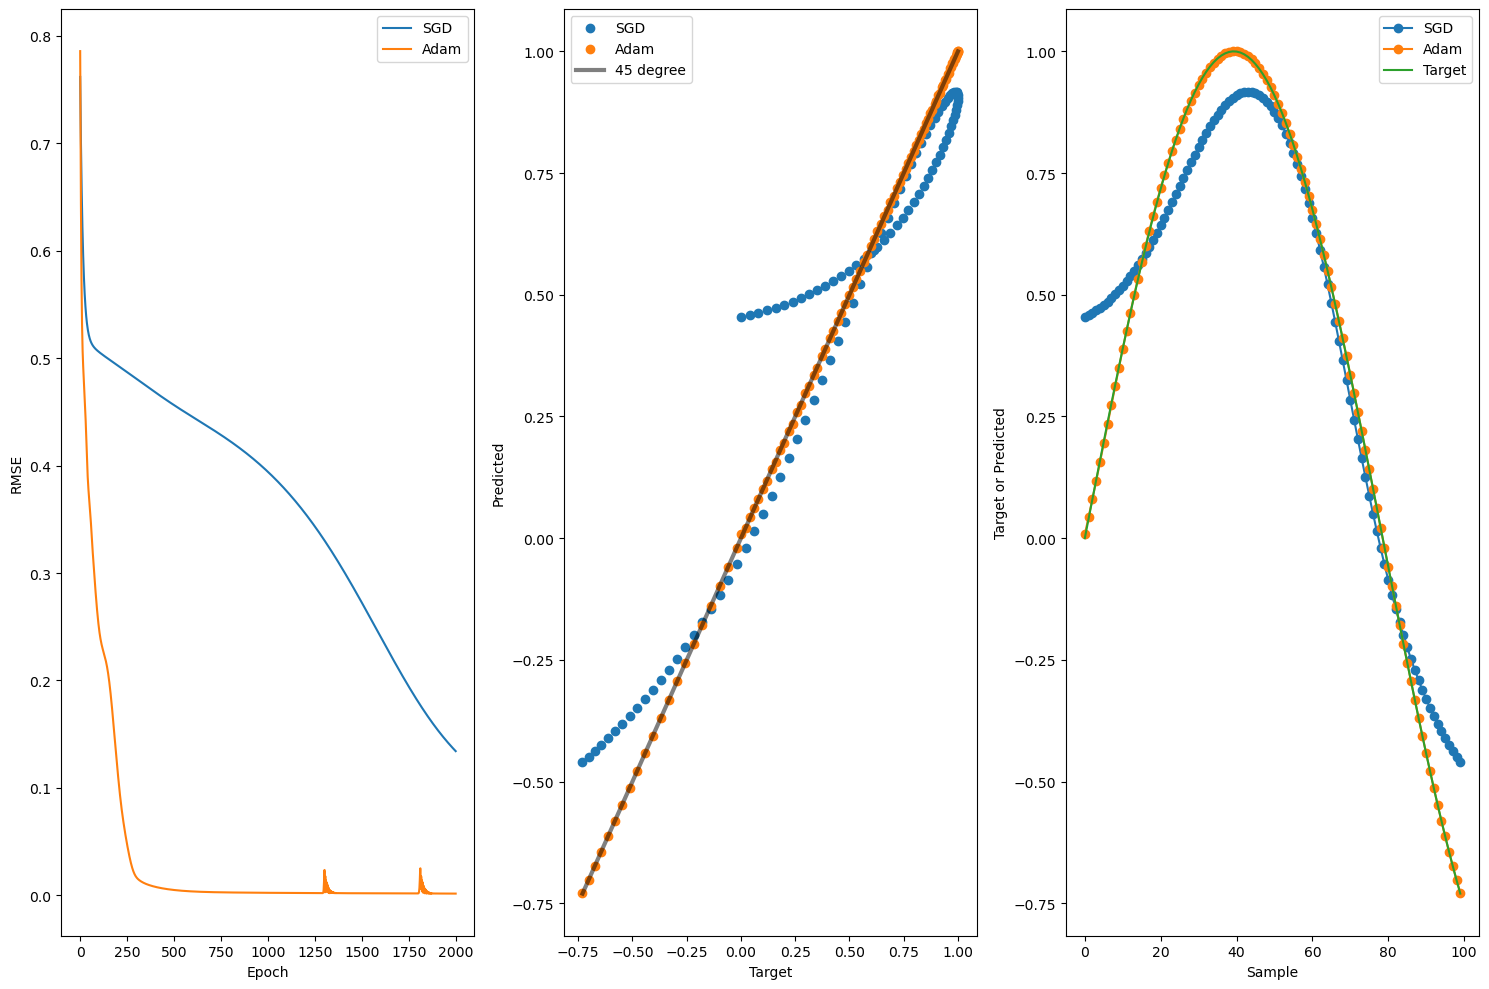

In [10]:
test_neuralnetwork()

## ReLU Activation Function

Cut and paste your `NeuralNetwork` class cell here.  Then modify it to allow the use of the ReLU activiation function, in addition to the `tanh` activation function that `NeuralNetwork` currently uses.  

Do this by
* Add the argument `activation_function` to the `NeuralNetwork` constructor that can be given values of `tanh` or `relu`, with `tanh` being its default value.
* Define two new class functions, `relu(s)` that accepts a matrix of weighted sums and returns the ReLU values, and `grad_relu(s)` that returns the gradient of `relu(s)` with respect to each value in `s`.
* Add `if` statements to `forward_pass` and `gradient_f` to selectively use the `tanh` or `relu` activation function. This is easy if you assign a new class variable in the `NeuralNetwork` constructor that has the value of the argument `activation_function`.

In [11]:
class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function ='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd',activation_function ='tanh'):
        '''train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self
    
    # Relu Function
    def relu(self, s):
        
        return np.maximum(0,s)
    
    def grad_relu(self, s):
        y= s.copy()
        y[y<0]=0
        y[y>=0]=1
        return y
   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        
        for W in self.Ws[:-1]:
            
            if self.activation_function == 'tanh':
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            elif self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                raise Exception("activation function must be 'tanh' or 'relu'")
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys


        
    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'tanh':
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
            elif self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T *self.grad_relu(self.Ys[layeri])
            else:
                raise Exception("activation function must be 'tanh' or 'relu'")
                
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction'''
        X = (X -  self.Xmeans) /self.Xstds   
        Y = self.forward_pass(X)
        Y=Y[-1]
        out = Y*self.Tstds +  self.Tmeans
        return out       
        

## Now for the Experiments!

Now that your code is working, let's apply it to some interesting data.

Read in the `auto-mpg.data` that we have used in lectures.  Let's apply neural networks to predict `mpg` using various neural network architectures, numbers of epochs, and our two activation functions.

This time we will partition the data into five parts after randomly rearranging the samples.  We will assign the first partition as the validation set, the second one as the test set, and the remaining parts will be vertically stacked to form the training set, as discussed in lecture.  We can use the RMSE on the validation set to pick the best values of the number of epochs and the network architecture.  Then to report on the RMSE we expect on new data, we will report the test set RMSE.

Read in the `auto-mpg.data` using `pandas` and remove all samples that contain missing values.  You should end up with 392 samples.

Now randomly reorder the samples.  First run `np.random.seed(42)` to guarantee that we all use the same random ordering of samples.

Partition the data into five folds, as shown in lecture.  To do this, complete the following function.

In [12]:
def partition(X, T, n_folds, random_shuffle=True):
    np.random.seed(42)
    rows = np.arange(X.shape[0])
    if random_shuffle:
        np.random.shuffle(rows)  # shuffle the row indices in-place (rows is changed)
        X = X[rows, :]
        T = T[rows, :]

    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)  # handles case when n_samples not evenly divided by n_folds

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )   # Changed in notes 07.2
    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]])
    return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest


In [13]:
import pandas
# names = pandas.read_csv("auto-mpg.names")
data=pandas.read_csv("auto-mpg.data",header=None,delim_whitespace=True, na_values="?")
data.isna().sum()
data = data.dropna()
data=data.iloc[:,:-1]
data = data.values

T = data[:,0:1]
X = data[:,1:]
# Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X,T,5)
X

array([[  8. , 307. , 130. , ...,  12. ,  70. ,   1. ],
       [  8. , 350. , 165. , ...,  11.5,  70. ,   1. ],
       [  8. , 318. , 150. , ...,  11. ,  70. ,   1. ],
       ...,
       [  4. , 135. ,  84. , ...,  11.6,  82. ,   1. ],
       [  4. , 120. ,  79. , ...,  18.6,  82. ,   1. ],
       [  4. , 119. ,  82. , ...,  19.4,  82. ,   1. ]])

In [14]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

Write a function named `run_experiment` that uses three nested for loops to try different values of the parameters `n_epochs`, `n_hidden_units_per_layer` and `activation_function` which will just be either `tanh` or `relu`. Don't forget to try `[0]` for one of the values of `n_hidden_units_per_layer` to include a linear model in your tests.  For each set of parameter values, collect the parameter values and the RMSE for the training, validation, and test set in a list.  When your loops are done, construct a `pandas.DataFrame` from the list of results, for easy printing.  The first five lines might look like:

```
   epochs        nh    lr act func  RMSE Train  RMSE Val  RMSE Test
0    1000       [0]  0.01     tanh    3.356401  3.418705   3.116480
1    1000       [0]  0.01     relu    3.354528  3.428324   3.125064
2    1000      [20]  0.01     tanh    1.992509  2.355746   2.459506
3    1000      [20]  0.01     relu    2.448536  2.026954   2.581707
4    1000  [20, 20]  0.01     tanh    1.518916  2.468188   3.118376
```
Your function must return a `pandas.DataFrame` like this one.

Before starting the nested for loops, your `run_experiment` function must first call your `partition` function to form the training, validation and test sets.

In [15]:
def run_experiment(X,T,n_folds,n_epochs_choices,n_hidden_units_per_layer_choices,activation_function_choices):
    learning_rate =0.01
    results=[]
    Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X,T,n_folds)
    for epoch in n_epochs_choices:
#         print(epoch)       
        for hidden_units in n_hidden_units_per_layer_choices:
#             print(hidden_units)
            for activation_func in activation_function_choices:
                nnet = NeuralNetwork(Xtrain.shape[1], hidden_units,Ttrain.shape[1],activation_func)
                nnet.train(Xtrain, Ttrain, epoch, learning_rate, method='adam',activation_function=activation_func)
                results.append([epoch, hidden_units, activation_func,
                                rmse(Ttrain, nnet.use(Xtrain)),
                                rmse(Tvalidate, nnet.use(Xvalidate)),
                                rmse(Ttest, nnet.use(Xtest))])
                df = pandas.DataFrame(results, columns=('epochs', 'nh', 'AF', 'train RMSE',
                                                    'validate RMSE', 'RMSE Test'))
#         print(df)  
    
    return df

An example call of your function would look like this:

In [16]:
result_df = run_experiment(X, T, n_folds=5, 
                           n_epochs_choices=[1000, 2000],
                           n_hidden_units_per_layer_choices=[[0], [10], [100, 10]],
                           activation_function_choices=['tanh', 'relu'])

Adam: Epoch 100 Error=3.78158
Adam: Epoch 200 Error=3.54286
Adam: Epoch 300 Error=3.47537
Adam: Epoch 400 Error=3.43532
Adam: Epoch 500 Error=3.41365
Adam: Epoch 600 Error=3.40252
Adam: Epoch 700 Error=3.39700
Adam: Epoch 800 Error=3.39434
Adam: Epoch 900 Error=3.39309
Adam: Epoch 1000 Error=3.39250
Adam: Epoch 100 Error=3.67969
Adam: Epoch 200 Error=3.53033
Adam: Epoch 300 Error=3.45684
Adam: Epoch 400 Error=3.42258
Adam: Epoch 500 Error=3.40645
Adam: Epoch 600 Error=3.39870
Adam: Epoch 700 Error=3.39500
Adam: Epoch 800 Error=3.39327
Adam: Epoch 900 Error=3.39250
Adam: Epoch 1000 Error=3.39217
Adam: Epoch 100 Error=3.08581
Adam: Epoch 200 Error=2.72877
Adam: Epoch 300 Error=2.61372
Adam: Epoch 400 Error=2.52511
Adam: Epoch 500 Error=2.43377
Adam: Epoch 600 Error=2.31631
Adam: Epoch 700 Error=2.21582
Adam: Epoch 800 Error=2.14736
Adam: Epoch 900 Error=2.08563
Adam: Epoch 1000 Error=2.02407
Adam: Epoch 100 Error=3.45732
Adam: Epoch 200 Error=3.05646
Adam: Epoch 300 Error=2.93268
Adam: E

In [17]:
result_df

,epochs,nh,AF,train RMSE,validate RMSE,RMSE Test
0,1000,[0],tanh,3.392493,3.342197,3.139467
1,1000,[0],relu,3.392163,3.335799,3.138626
2,1000,[10],tanh,2.023533,2.529672,3.011884
3,1000,[10],relu,2.813380,2.585957,2.945995
4,1000,"[100, 10]",tanh,0.628187,3.170954,3.197973
5,1000,"[100, 10]",relu,2.703286,2.512798,2.949089
6,2000,[0],tanh,3.391963,3.327554,3.138830
7,2000,[0],relu,3.391964,3.327876,3.138808
8,2000,[10],tanh,1.679776,3.191265,3.328709
9,2000,[10],relu,2.812549,2.649781,2.986426


Find the lowest value of `RMSE Val` in your table and report the `RMSE Test` and the parameter values that produced this.  This is your expected error in predicted miles per gallon.  Discuss how good this prediction is.

Plot the RMSE values for training, validation and test sets versus the combined parameter values of number of epochs and network architecture.  Make one plot for `tanh` as the activation function and a second one for `relu`.  Your plots should look like this, but with different RMSE values, and will of course be different if you choose different network architectures and numbers of epochs.

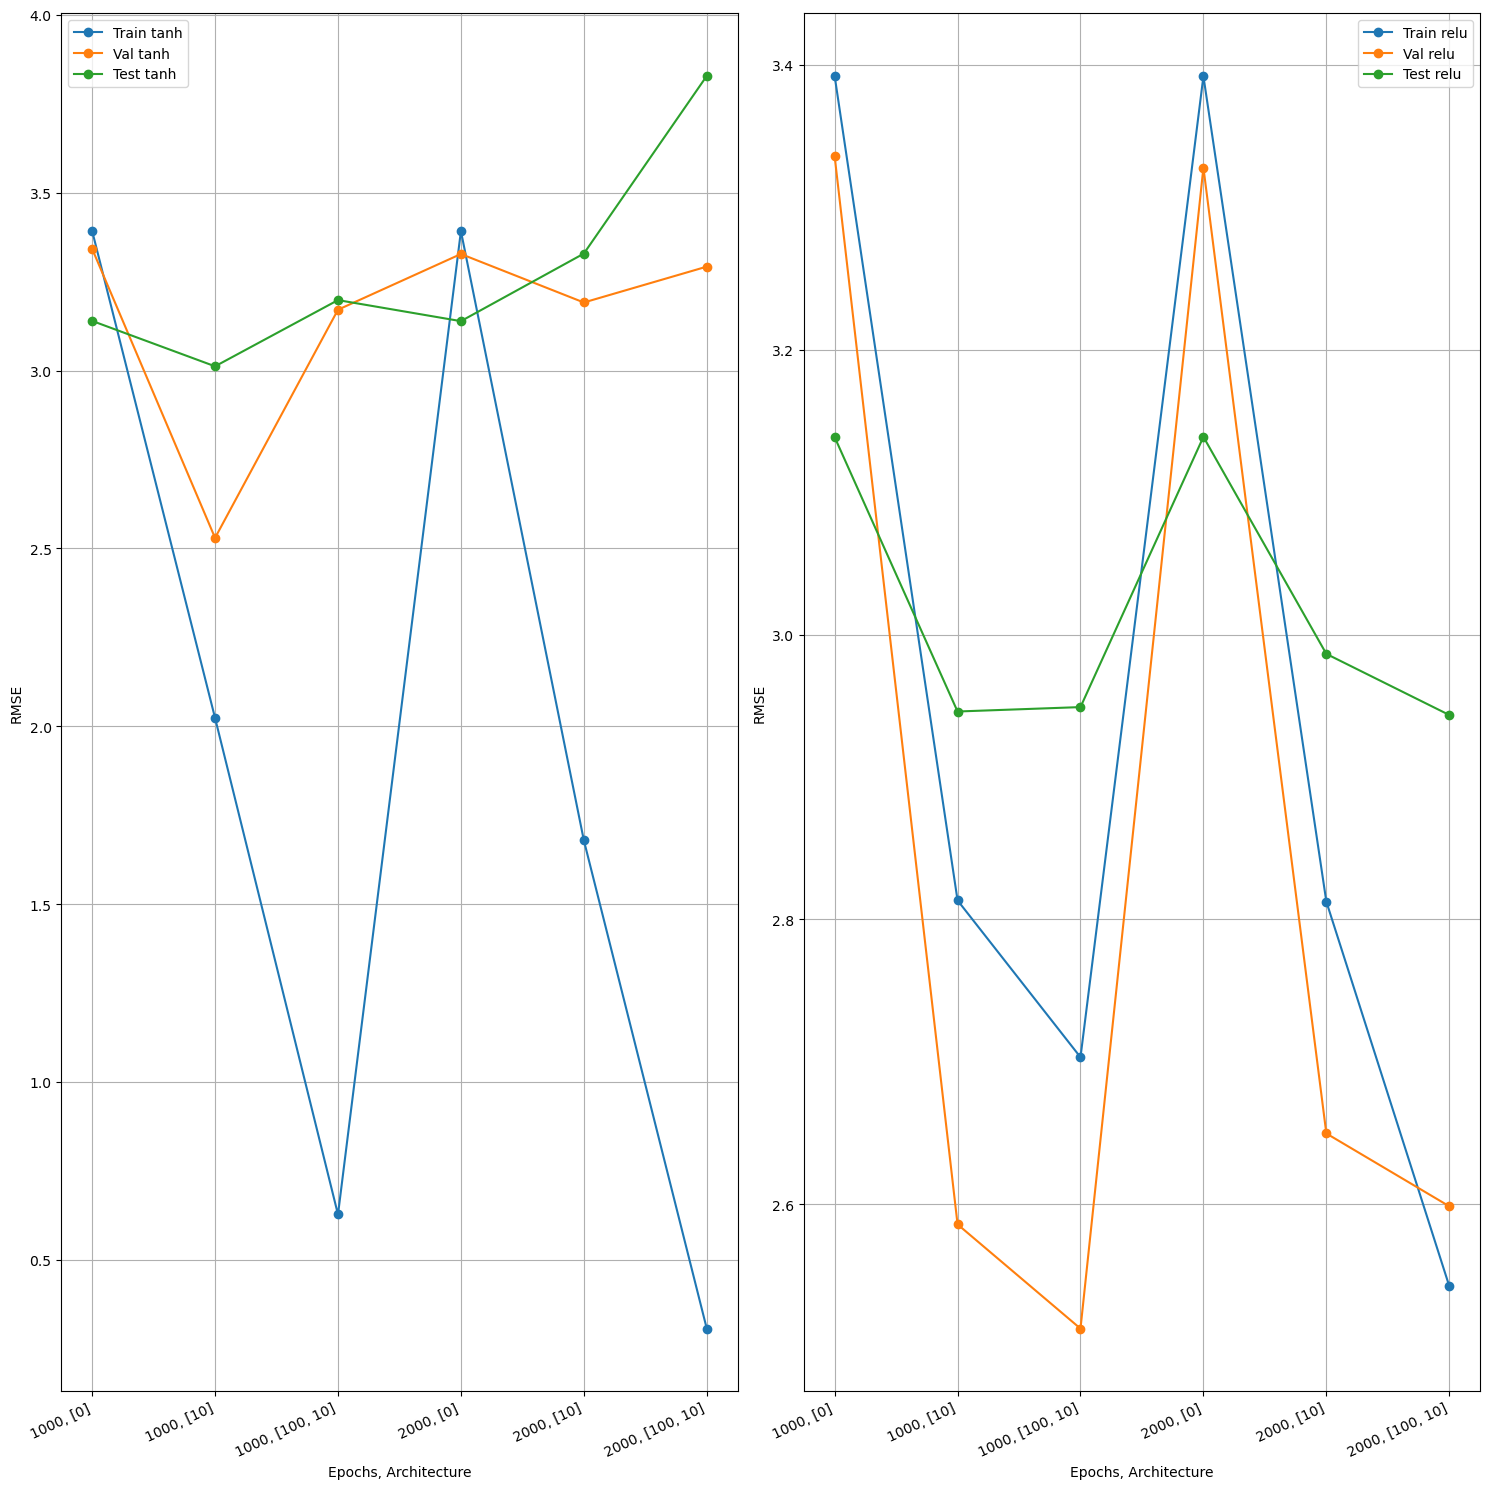

In [19]:

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
df = result_df
plt.subplot(1, 2, 1)
dfsgd = df[(df['AF'] == 'tanh')]
xs = range(dfsgd.shape[0])
plt.plot(xs, dfsgd[['train RMSE', 'validate RMSE', 'RMSE Test']], 'o-')
xticks = dfsgd[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) # converting to strings
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
# plt.ylim(0, 7)
plt.ylabel('RMSE')
plt.legend(('Train tanh', 'Val tanh', 'Test tanh'))
plt.grid('on')

plt.subplot(1, 2, 2)
dfadam = df[(df['AF'] == 'relu')]
xs = range(dfadam.shape[0])
plt.plot(xs, dfadam[['train RMSE', 'validate RMSE', 'RMSE Test']], 'o-')
xticks = dfadam[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train relu', 'Val relu', 'Test relu'))
plt.grid('on')

plt.tight_layout();

<h3><b>Describe at least three different observations you make about these plots.  What do you find interesting?</b></h3>

*However, a few tentative observations can be made. it appears that increasing the number of epochs generally leads to better performance, although this effect may be limited after a certain point*
* The model with Activation function **Tanh** has the least validation RMSE value of **2.529672**  and the respective test validation RMSE of **3.011884** for the following Configuration:
    * epochs: **1000**
    * Nueral Network: **1** layer with **10** nodes
    * Learning rate: **0.01** 


* The model with Activation function **Relu** has the least validation RMSE value of **2.512798**  and the respective test validation RMSE of **2.949089** for the following Configuration:
    * epochs: **1000** 
    * Nueral Network: **2** layer with **100 and 10** nodes
    * Learning rate: **0.01** 
    

* With increasing hidden layers the training RMSE value with Tanh activation function reduces significantly but the validation  and test RMSE values are not satisfactory.

* In Tanh activation model inspite of having the least training RMSE vlaue there is a significant spike in the test and validation RMSe values.

* In Relu activation model the least training RMSE value was observed for the below configuration but the test and validation values spike significantly.
    * epochs: **20000** 
    * Nueral Network: **3** layer with **20** nodes each
    * Learning rate: **0.01** 
    for 
* adding additional hidden layers and nodes may improve performance, although this is not always the case. Finally, the choice of activation function appears to have a significant impact on performanceFor the auto-mpg data we can observe that relu activation function performs better than tanh function.



## Grading and Check-in

Your notebook will be partially run and graded automatically. Test this grading process by first downloading [A2grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A2grader.zip) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect execution score of 70/70 if your functions are defined correctly. The remaining 30 points will be based on other testing and the results you obtain and your discussions.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.

For the grading script to run correctly, you must first name this notebook as `Lastname-A2.ipynb`| with Lastname being your last name, and then save this notebook and check it in at the A2 assignment link in our Canvas web page.

In [19]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Karra-A2(2).ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook Karra-A2(2).ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmin) ** 2 + 2 * (w[0] - wmin)
  wmin = 0.5
  opt = Optimizers(w)
  errors_sgd = opt.sgd(cubic, grad_cubic, [wmin], 100, 0.01)

sgd: Epoch 10 Error=0.11889
sgd: Epoch 20 Error=0.11092
sgd: Epoch 30 Error=0.10176
sgd: Epoch 40 Error=0.09162
sgd: Epoch 50 Error=0.08081
sgd: Epoch 60 Error=0.06972
sgd: Epoch 70 Error=0.05879
sgd: Epoch 80 Error=0.04844
sgd: Epoch 90 Error=0.03901
sgd: Epoch 100 Error=0.03072

--- 10/10 points. Returned correct value.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmin) ** 2 + 2 * (w[0] - wmin)
  wmin = 0.5
  opt = Optimizers(w)
  errors_adam = opt.adam(cubic, grad_cubic, [wmin], 100, 0.01)

Adam: Epoch 10 Error=0.09899
Ada

## Extra Credit: 1 point

Add the Swish activation function as a third choice in your `train` function in your `NeuralNetwork` class.
A little googling will find definitions of it and its gradient.  Start with [this article](https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/#todays-activation-functions).

Use your `run_experiment` function to compare results for all three activation functions.  Discuss the results.

In [ ]:
from keras.backend import sigmoid